#**Text Translation And Summarization Using Deep Neural Networks**
### Introduction

In this notebook, we will see how to translate a given article in French to English and then summarize it. We have initially used an attention model for text translation to convert the sorce data which is in french into english. For text summarization we have used a hybrid model with extractive and abstractive summarizer models. The objective of the extractive summarizer is to reduce the size of the input text by only considering the important sentences in the text. The output from the extractive model is given to the abstractive model which is an encoder decoder neural network model. This model gives us the final summary which is evaluated against the predicted summary using Bleu and Rouge metrics.

### Import the required Libraries
Out first objective for this is to load the required libraries

In [ ]:
!pip install contractions

import pandas as pd 
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import unicodedata
import re
import numpy as np
import time
import string
import math

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import networkx as nx
nltk.download('punkt')
nltk.download('stopwords')

# Rouge and Bleu metrics are used for evaluating the models
!pip install rouge_score
import scipy.stats
import seaborn as sns
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

# To ignore the warning messages because of changes in libraries
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Enabling and testing the GPU

First, you'll need to enable GPU for the notebook:


*   Navigate to Edit→Notebook Settings
*   select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 119623918040705464
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8444827131927327348
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


### Define the distribution strategy

Create a MirroredStrategy object. This will handle distribution and provide a context manager (MirroredStrategy.scope) to build our model inside. Access to faster GPUs and TPUs means you spend less time waiting while your code is running. 

In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### Mounting google drive and saving all checkpoints

We have stored some information which are loaded everytime we need to run the code in our drive (these files too are updated in the github). The training checckpoints are stored incase there is a timeout and the model stops running. Also we wanted to spped up the process if we need to test the model with a few changes. Glove for embedding is also stored in the drive. We have also mentioned an alternative which downloads it in the current session.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

checkpoint_dir_translate = './drive/MyDrive/training_checkpoints'
checkpoint_prefix_translate = os.path.join(checkpoint_dir_translate, "ckpt")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Expanding contractions

Contractions are words or combinations of words that are shortened by dropping letters and replacing them by an apostrophe. Nowadays, where everything is shifting online, we communicate with others more through text messages or posts on different social media like Facebook, Instagram, Whatsapp, Twitter, LinkedIn, etc. in the form of texts. With so many people to talk, we rely on abbreviations and shortened form of words for texting people.

In [ ]:
from contractions import contractions_dict

def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

### Removing punctuations

The punctuations present in the text do not add value to the data. The punctuation, when attached to any word, will create a problem in differentiating with other words.

In [ ]:
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)


### Removing numbers

Similar to punctuation numbers are also not as important so we remove them to make the computation easier.

In [ ]:
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  

### Removing stop words

Stopwords include: I, he, she, and, but, was were, being, have, etc, which do not add meaning to the data. So these words must be removed which helps to reduce the features from our data.

In [ ]:
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

### Text cleaning

We will perform the below preprocessing tasks for our data:

*   Convert everything to lowercase
*   Remove HTML tags
*   Contraction mapping
*   Remove (‘s)
*   Remove any text inside the parenthesis ( )
*   Eliminate punctuations and special characters
*   Remove stopwords
*   Remove short words

In [ ]:
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing extra white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

### Loading the datset for training translation model

All the data set can be found in the same github repository. We first load the data from our text files into english_sentences and french_sentences sentences respectively by reading each line of the text file by cleaning the line. We have found a preprocessed clean dataset for translation purpose. We just need to do small changes to it like removing the unnecessary trailing spaces, converting the text to lower case and removing punctuation to create better bag of vocabulary.

In [ ]:
import contractions

eng_file = 'English_data.txt'
fre_file = 'French_data.txt'
# Load English data
english_sentences = []
with open(eng_file) as f:
    for line in f:
      expanded_words = ''  
      for word in line.split():
        # using contractions.fix to expand the shotened words
        expanded_words += ' ' + contractions.fix(word) 
      line = expanded_words.rstrip()
      line = line.lower()
      line = re.sub(r'[^\w\s]', '', line)
      line = '<start> ' + line + ' <end>'
      english_sentences.append(line)
# Load French data
french_sentences = []
with open(fre_file) as f:
    for line in f:
      line = line.lower()
      line = re.sub(r'[^\w\s]', '', line)
      line = '<start> ' + line + ' <end>'
      french_sentences.append(line)
sent_pairs = [[a_, b_] for a_, b_ in zip(french_sentences, english_sentences)]

In [ ]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word
def max_length(tensor):
    return max(len(t) for t in tensor)

Word Embeddings or Word vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which used to find word predictions, word similarities/semantics.

In [ ]:
def load_dataset(pairs, num_examples):

    # index language using the class defined above    
    inp_lang = LanguageIndex(en for en, ma in pairs)
    targ_lang = LanguageIndex(ma for en, ma in pairs)
    
    # Vectorize the input and target languages
    
    # French sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, ma in pairs]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in ma.split(' ')] for en, ma in pairs]
    
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(sent_pairs, len(english_sentences))

The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

In [ ]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1, random_state = 101)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

### Encoder - Decoder model for text translation

Here, we are implementing an encoder-decoder model with attention

In [ ]:
def gru(units):

    return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')
    
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):

        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        x = self.embedding(x)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output, state = self.gru(x)

        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

### Define the optimizer and the loss function

In [ ]:
# Adam optimizer for our model
optimizer = tf.optimizers.Adam()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training translation model

1. Pass the input through the encoder which will return encoder output and the encoder hidden state.
2. The encoder output, encoder hidden state and the decoder input are passed to the decoder.
3. The decoder returns the predictions and the decoder hidden state.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Using teacher forcing to decide the next input to the decoder.
6. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
EPOCHS = 1

# We have trained the model on several epochs and stored the training details in a checkpoint. We now just neet to run for 1 epoch to get good results.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_prefix_translate))

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every epoch
    # checkpoint.save(file_prefix = checkpoint_prefix_translate)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.0720
Epoch 1 Batch 100 Loss 1.0894
Epoch 1 Batch 200 Loss 0.8924
Epoch 1 Batch 300 Loss 0.8590
Epoch 1 Batch 400 Loss 0.7913
Epoch 1 Batch 500 Loss 0.7269
Epoch 1 Batch 600 Loss 0.6561
Epoch 1 Batch 700 Loss 0.5898
Epoch 1 Batch 800 Loss 0.5870
Epoch 1 Batch 900 Loss 0.5256
Epoch 1 Batch 1000 Loss 0.4339
Epoch 1 Batch 1100 Loss 0.3952
Epoch 1 Batch 1200 Loss 0.4401
Epoch 1 Batch 1300 Loss 0.3096
Epoch 1 Batch 1400 Loss 0.2373
Epoch 1 Batch 1500 Loss 0.1417
Epoch 1 Batch 1600 Loss 0.1269
Epoch 1 Batch 1700 Loss 0.0880
Epoch 1 Batch 1800 Loss 0.0909
Epoch 1 Batch 1900 Loss 0.0949
Epoch 1 Loss 0.5420
Time taken for 1 epoch 1176.2511394023895 sec



### Translate

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* We will stop predicting when the model predicts the end token and store the attention weights for every time step.


In [ ]:
def evaluate(inputs, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = ''
    for i in inputs[0]:
        if i == 0:
            break
        if i > len(inp_lang.idx2word):
            i = 4
        sentence = sentence + inp_lang.idx2word[i] + ' '
    sentence = sentence[:-1]
    
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
def predict_random_val_sentence():
    actual_sent = ''
    k = np.random.randint(len(input_tensor_val)) 
    random_input = input_tensor_val[k]
    random_output = target_tensor_val[k]
    random_input = np.expand_dims(random_input,0)
    result, sentence, attention_plot = evaluate(random_input, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    print('Input: {}'.format(sentence[8:-6]))
    print('Predicted translation: {}'.format(result[:-6]))
    for i in random_output:
        if i == 0:
            break
        if i > len(targ_lang.idx2word):
            i = 4
        actual_sent = actual_sent + targ_lang.idx2word[i] + ' '
    actual_sent = actual_sent[8:-7]
    print('Actual translation: {}'.format(actual_sent))

In [ ]:
predict_random_val_sentence()

Input: elle aime les pêches  les fraises et les citrons verts 

Predicted translation:  she likes bananas  strawberries  and limes  
Actual translation:  she likes peaches  strawberries  and limes 


In [ ]:
predict_random_val_sentence()

Input: californie est jamais chaude en octobre  et il est parfois doux à l automne 

Predicted translation:  california is never hot during october  and it is sometimes mild in fall  
Actual translation:  california is never hot during october  and it is sometimes mild in fall 


In [ ]:
predict_random_val_sentence()

Input: paris est jamais agréable au mois d août  et il est relaxant habituellement en novembre 

Predicted translation:  paris is never nice during august  and it is usually relaxing in november  
Actual translation:  paris is never pleasant during august  and it is usually relaxing in november 


### Evaluation using rouge score for translation.

In [ ]:
pred_summaries_train = []
true_summaries_train = []
for i in range(1000):
  actual_sent = ''
  k = np.random.randint(len(input_tensor_val)) 
  random_input = input_tensor_val[k]
  random_output = target_tensor_val[k]
  random_input = np.expand_dims(random_input,0)
  result, sentence, attention_plot = evaluate(random_input, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
  for i in random_output:
      if i == 0:
          break
      if i > len(targ_lang.idx2word):
          i = 4
      actual_sent = actual_sent + targ_lang.idx2word[i] + ' '
  actual_sent = actual_sent[8:-7]
  pred_summaries_train.append(result[:-6])
  true_summaries_train.append(actual_sent)

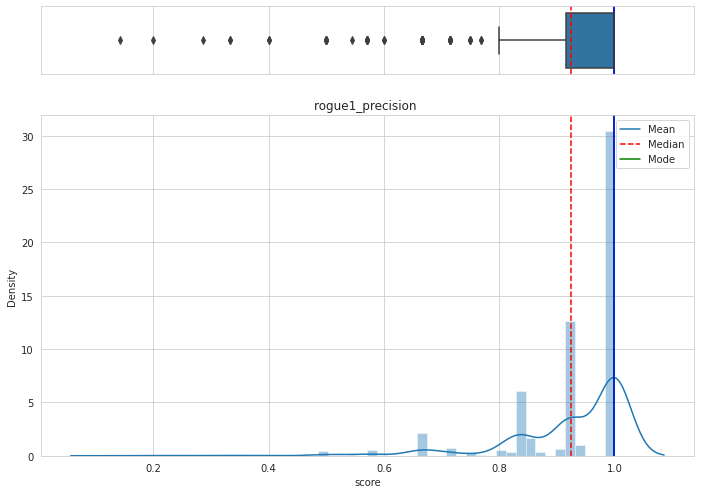

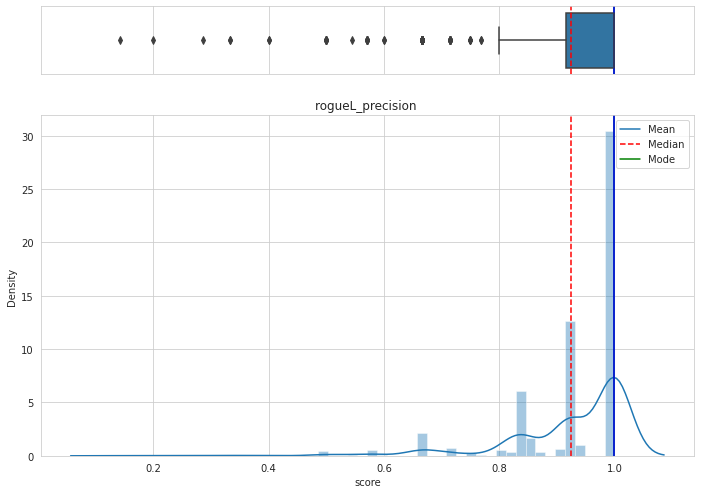

In [ ]:
def compute_summary_stats(scores):
  def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
  stats = {}
  for key in scores.keys():
    stats[key] = mean_confidence_interval(scores[key])
  return stats

def plot_scores(scores, label_text, val = 'rogue1_precision'):
  for measure in scores.keys():
    df = pd.DataFrame({"score":scores[val] , "dummy": range(len(scores[val]))})
    sns.set_style("whitegrid")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
    f.set_size_inches(11.7, 8.27)
    mean=df['score'].mean()
    median=df['score'].median()
    mode=df['score'].mode()[0]

    sns.boxplot(df["score"], ax=ax_box)
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.axvline(mode, color='b', linestyle='-')

    sns.distplot(df["score"], ax=ax_hist)
    ax_hist.axvline(mean, color='r', linestyle='--')
    ax_hist.axvline(median, color='g', linestyle='-')
    ax_hist.axvline(mode, color='b', linestyle='-')

    plt.legend({'Mean':mean,'Median':median,'Mode':mode})
    plt.title(f'{measure} {label_text}')
    ax_box.set(xlabel='')
    plt.show()

def compute_rouge(pred_summaries, true_summaries):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
  rogue1_precision = []
  rogueL_precision = []
  for i in range(len(pred_summaries)):
    score = scorer.score(pred_summaries[i], true_summaries[i])
    rogue1_precision.append(score['rouge1'].precision)

    rogueL_precision.append(score['rougeL'].precision)

  scores = {'rogue1_precision':rogue1_precision,'rogueL_precision':rogueL_precision}
  return scores

scores_train =  compute_rouge(pred_summaries_train, true_summaries_train)

compute_summary_stats(scores_train)

plot_scores(scores_train, '')

### Evaluation using bleu score for translation

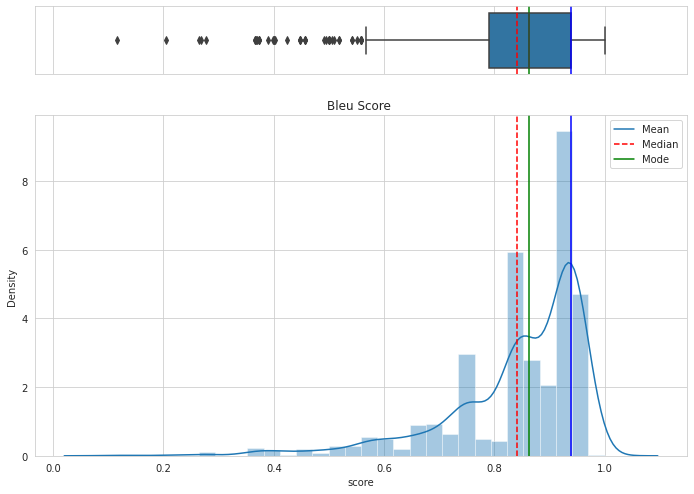

In [ ]:
def compute_bleu(pred_summaries, true_summaries):
  bleu_score = []
  for i in range(len(pred_summaries)):
    reference = pred_summaries[i].split(' ')
    hypothesis = true_summaries[i].split(' ')
    score =  sentence_bleu([reference], hypothesis, weights = (0.5, 0.5))
    bleu_score.append(score)

  scores = {'Bleu Score':bleu_score}
  return scores


scores_train =  compute_bleu(pred_summaries_train, true_summaries_train)

compute_summary_stats(scores_train)

plot_scores(scores_train, '', 'Bleu Score')

## Summarization

### Loading data sets for training summarization model.
Load the data sets from the github and remove the unnecessary columns. 

In [ ]:
filename1 = '/content/news_summary.csv'
filename2 = '/content/news_summary_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
49667,"HC asks Centre to act against BJP, Cong in fun...",Delhi High Court gave the Home Ministry six we...
76369,Tinder faces login issues after Facebook priva...,Dating app Tinder faced outage on Wednesday du...
62590,Still waiting to see if IndiGo bids for Air In...,Civil Aviation Secretary RN Choubey has said t...
272,Selectors told Dhoni time has come to move on ...,Before excluding MS Dhoni from the squads for ...
48747,Ã¢ÂÂ¹1.17cr spent on food during Jaya's 75-da...,As much as Ã¢ÂÂ¹1.17 crore was spent on food ...


### Data cleaning
Cleaning both text and summary and adding `start` and `end` tokens in `headlines(summary)` to let the learning algorithm know from where the headlines start's and end's.

It's important to use `sostok` and `eostok` as start and end tokens respectively as later while using `tensorflow's Tokenizer`, it will filter the tokens and covert them to lowercase.

**sostok** & **eostok** tokens are used to let us know where to start & stop the summary because using `_START_` & `_END_`, tf's tokenizer with convert them to **start** & **end** respectively.

So while decoding the summary sequences of sentences like **'everything is going to end in 2012'** if use `_START_` & `_END_` tokens (which will make the sentence like **'start everything is going to end in 2012 end'** this)  tf's tokenizer will convert start and end then we will stop decoding as we hit first **end**, To avoid this **sostok** & **eostok** tokens are used.

In [ ]:
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)

df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)

df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

In [ ]:
df.sample(5)

,headlines,text
99214,sostok _START_ yonex instagram handle gets hac...,official instagram account sports merchandise ...
24816,sostok _START_ ambani may buy majority stake e...,mukesh ambani close acquiring majority stake m...
43763,sostok _START_ kerala hc allows iage registrat...,kerala high court ruled couples seeking get ia...
101235,sostok _START_ aaps punjab ally breaks allianc...,lok insaaf party lip broke alliance aam aadmi ...
96322,sostok _START_ delhi end surge pricing ban cen...,delhi government planning prohibit taxi driver...



Finding what should be the maximum length of text and headlines that will be feed or accepted by the learning algorithm.

In [ ]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

## Extractive summarizer 

In Extractive summarization, we identify the important sentences or phrases from the original text and extract only those sentences which will be considered as the input to the abstractive summarizer.

In [ ]:
def sentence_similarity(sent1,sent2):    
      
  sent1 = [w.lower() for w in sent1]    
  sent2 = [w.lower() for w in sent2]
        
  all_words = list(set(sent1 + sent2))   
     
  vector1 = [0] * len(all_words)    
  vector2 = [0] * len(all_words)        
  # Build the vector for the first sentence    
  for w in sent1:        
    vector1[all_words.index(w)]+=1                                                           
  # Build the vector for the second sentence    
  for w in sent2:                    
    vector2[all_words.index(w)]+=1 
               
  return 1-cosine_distance(vector1,vector2)

def build_similarity_matrix(sentences):
  # Create an empty similarity matrix
  similarity_matrix = np.zeros((len(sentences),len(sentences)))
  for idx1 in range(len(sentences)):
      for idx2 in range(len(sentences)):
        if idx1!=idx2:
          similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1],sentences[idx2])
  return similarity_matrix

def generate_summary(sentences,top_n):  
  summarize_text = []
  # Read text and tokenize    
  # Generate similarity matrix            
  sentence_similarity_matrix = build_similarity_matrix(sentences)
  # Rank sentences in similarity matrix
  sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
  scores = nx.pagerank(sentence_similarity_graph)
  # Sort the rank and place top sentences
  ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)),reverse=True)
  
  # Get the top n number of sentences based on rank
  for i in range(top_n):
    summarize_text.append(ranked_sentences[i][1])
  # Output the summarized version
  return " ".join(summarize_text)

for index, row in df.iterrows():
  sentences = sent_tokenize(row['text'])
  val = math.ceil(len(sentences)*0.75)
  df['text'][index] = generate_summary(sentences,val)

If the length of headlines or the text is kept large the deep learning model will face issues with performance and also training will slower.

One solution for creating summary for long sentences can be break a paragraph into sentences and then create a summary for them, this way the summary will make sence instead of giving random piece of text and creating summary for it.

In [ ]:
max_text_len = 42
max_summary_len = 13

def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 100235


,text,summary
20340,home minister rajnath singh sunday launched we...,sostok _START_ portal launched donate money yr...
62890,barcelona beat la liga champions real madrid e...,sostok _START_ messi scores barcelona beat ron...
49264,indian gymnast dipa karmakar finished fourth r...,sostok _START_ dipa karmakar ruled commonwealt...
76573,per reports actress katrina kaif turn producer...,sostok _START_ katrina turn producer launch si...
26504,many infrastructure projects worth aaa1 crore ...,sostok _START_ infra projects witness cost ove...


### Rare word analysis

In [ ]:
def get_rare_word_percent(tokenizer, threshold):
    # Threshold: If the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

### Splitting the training and validation sets

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

### Tokenizing text and summary

Tokenize the text and summary data and pad them to match with maximum length.



In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)

# One-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# Padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

x_vocab_size = len(x_tokenizer.word_index) + 1


y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)

y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# Padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

y_vocab_size = len(y_tokenizer.word_index) + 1

### Removing Empty Texts and Summaries
Removing all empty summaries (which only have START and END tokens) and their associated texts from the data.

In [ ]:
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

### Preparing embedding matrix

Using pre-trained embeddings and keeping the Embedding layer non-trainable we get increase in computation speed as don't need to compute the embedding matrix. So we are using glove embeddings.


In [ ]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = '/content/drive/MyDrive/glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 55325 words (44541 misses)
Found 400000 word vectors.
Converted 27057 words (10355 misses)


In [ ]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(99867, 300)
(37413, 300)


## Abstractive summarizer model

**Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
### Encoder:
The input length that the encoder accepts is equal to the maximum text length is already calculated in the above steps. This is then given to an Embedding Layer of dimension 300. This is followed by 2 LSTM networks wherein each layer returns the LSTM output, as well as the hidden and cell states observed at the previous time steps.

### Decoder:
In the decoder, an embedding layer is defined followed by an LSTM network. The initial state of the LSTM network is the last hidden and cell states taken from the encoder. The output of the LSTM is given to a Dense layer wrapped in a TimeDistributed layer with an attached softmax activation function.

Altogether, the model accepts encoder (text) and decoder (summary) as input and it outputs the summary. The prediction happens through predicting the upcoming word of the summary from the previous word of the summary.


In [ ]:
def build_seq2seq_model(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    with strategy.scope():

        # Encoder
        encoder_input = Input(shape=(max_text_len, ))

        # Encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # Encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # Encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # Decoder

        # Set up the decoder, using encoder_states as initial state.

        decoder_input = Input(shape=(None, ))

        # Decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # Decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # Dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # Model
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

### Model summary

In [ ]:
seq2seq = build_seq2seq_model(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 42, 300)      29960100    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 42, 240),    519360      ['embedding_2[0][0]']            
                                 (None, 240),                                                 

In [ ]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

### Training the Model
Compile the model and define `EarlyStopping` to stop training the model once the validation loss metric has stopped decreasing.

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

### Fitting the model

Using the model.fit() method to fit the training data where we can define the batch size to be 128. Send the text and summary (excluding the last word in summary) as the input, and a reshaped summary tensor comprising every word (starting from the second word) as the output (which explains the infusion of intelligence into the model to predict a word, given the previous word). Besides, to enable validation during the training phase, send the validation data as well.

In [ ]:
checkpoint_dir_summ = '/content/drive/MyDrive/abstractive_model'
checkpoint_prefix_summ = os.path.join(checkpoint_dir_summ, "ckpt")
# model.load_weights(checkpoint_prefix_summ)

history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs = 2,
    batch_size=128 * strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )

)

model.save_weights(checkpoint_prefix_summ)

Epoch 1/2
705/705 [==============================] - 576s 816ms/step - loss: 3.7647 - accuracy: 0.4961 - val_loss: 3.6663 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 2/2
705/705 [==============================] - 603s 855ms/step - loss: 3.6947 - accuracy: 0.5026 - val_loss: 3.6252 - val_accuracy: 0.5113 - lr: 0.0010


### Plotting model performance's

Plotting the training and validation loss metrics and accuracies observed during the training phase.

Since we are running from the saved checkpoint, the accuracy and loss graphs are not accurately shown. 

In [ ]:
# Accuracy
#plt.plot(history.history['accuracy'][1:], label='train acc')
#plt.plot(history.history['val_accuracy'], label='val')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.legend(loc='lower right')

In [ ]:
# Loss
#plt.plot(history.history['loss'][1:], label='train loss')
#plt.plot(history.history['val_loss'], label='val')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend(loc='upper right')

### Generating Predictions

Now that we've trained the model, to generate summaries from the given pieces of text, first reverse map the indices to the words (which has been previously generated using texts_to_sequences). Also, map the words to indices from the summaries tokenizer which is to be used to detect the start and end of the sequences.

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

### Inference phase
Now the encoder and decoder inference models are defined to start making the predictions using the tensorflow.keras.Model() object.</br>
An encoder inference model accepts text and returns the output generated from the LSTMs, and hidden and cell states. A decoder inference model accepts the start of the sequence identifier (sostok) and predicts the upcoming word, eventually leading to predicting the whole summary.

In [ ]:
def build_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
encoder_model, decoder_model = build_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

Now a function decode_sequence_seq2seq_model() is defined which accepts the input text and outputs the predicted summary. Starts with sostok and continues generating words until eostok is encountered or the maximum length of the summary is reached. Predicts the upcoming word from a given word by choosing the word which has the maximum probability attached and updates the internal state of the decoder accordingly.

In [ ]:
def decode_sequence_seq2seq_model(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


seq2summary() converts numeric-representation to string-representation of summary.

In [ ]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

seq2text() converts numeric-representation to string-representation of text.

In [ ]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

### Predictions 


In [ ]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # Breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # To remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary


Predicting the summary and printing it along with news and orginal summary

In [ ]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  maharashtra forest minister sudhir mungantiwar wednesday told legislative council government planning relocate tigers vidarbha region sanctuaries tiger population smaller added deaths tigers happen due territorial fights caused overpopulation committee reportedly formed examine proposal 
Original summary:  start maharashtra government considers relocating tigers end 
Predicted summary:   start maha govt seeks action farmers maha cm end

# 2 News:  former pakistan cricket coach bob woolmer found dead hotel room jamaica day pakistan knocked world cup minnows ireland suspecting murder local authorities launched investigation death later ared woolmer died natural causes 
Original summary:  start yrs since pak coach found dead teams wc ouster end 
Predicted summary:   start pak captain found dead cricket cricket team end

# 3 News:  speaking rape cases minors madhya pradesh chief minister shivraj singh chouhan said state become role model giving death sentence offenders added one

### Evaluation using rouge and bleu scores for summarization.

In [ ]:
pred_summaries_train = []
true_summaries_train = []
for i in range(1000):
  actual_sent = ''
  k = np.random.randint(len(input_tensor_val)) 
  pred_summaries_train.append(seq2summary(y_train_padded[k]))
  true_summaries_train.append(decode_sequence_seq2seq_model(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        ))

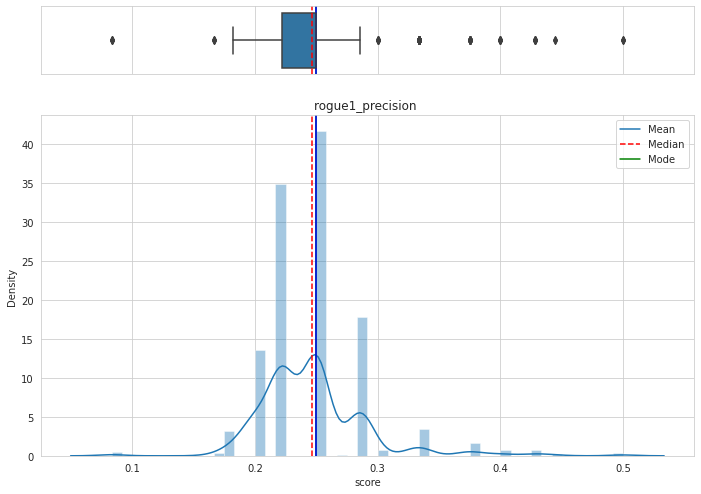

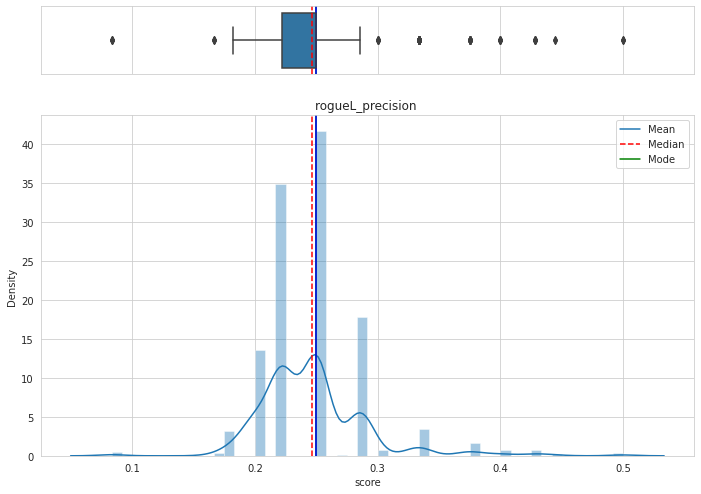

In [ ]:
scores_train =  compute_rouge(pred_summaries_train, true_summaries_train)

plot_scores(scores_train, '')


### Evaluations for summarization using bleu score

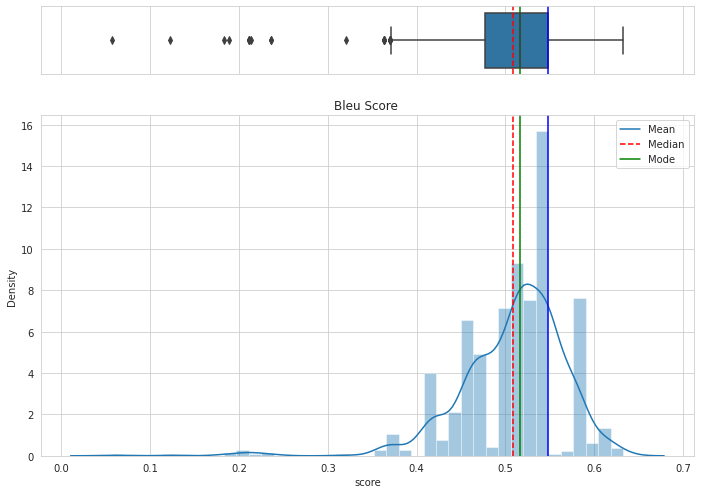

In [ ]:
scores_train =  compute_bleu(pred_summaries_train, true_summaries_train)

plot_scores(scores_train, '', 'Bleu Score')